   # ReadMe
   For our project we wanted to train a convolutional neural network to classify a room as dirty or clean. We feel that while this may seem like a simplistic implementation of CNN's if we can create an accurate enough model there will be plenty of viable ways our algorithm can be applied. Our interest lies in the hospitality services market, where people are becoming increasingly comfortable living in and maintaing other peoples residences. While Airbnb places the onus on the host to maintain a clean environment for each guest, they are unable to verify the that this has been done until the guest provides a review after the fact. This inability to validate or screen the current states of their properties has left the door open for competitors to emerge, with the promise of a more quality assurance and consistent property maintenance. Even for these other companies who take on the role of maintaining their properties, they must employ a rather inefficeint process of paying for each property to be cleaned after each guest. And while this may be preferable to the clientelle, it can often result in avoidable monetary expenses in part due to the lack of current information they have on each property. 

   We feel that any company in this  market would be at an advantage if they were able to determine the condition of each property after a patron had checked out. For a company like Airbnb this could provide valuable additional profile information for the individuals who list their property on their website. And for Domio this could greatly streamline their over-generalized cleaning procedure, or possibly result in a groundup restructuring of how properties are passed on from one patron to the next.
   Instead of paying a flat fee for a cleaning service to do an arbitrary amount of work this algorithm at the very least would provide the hospitality service a way to measure the amount of work that needs to be done. And at the most our model could exist at the center of an ecosystem in which the party checking out and checking in agree to a certain level of cleanliness and save money as a result, completley cutting out the cleaning fee. 

__Import necessary libraries__

In [139]:
import os, shutil
import numpy as np
import pandas as pd 
import matplotlib as plt
import time
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from keras import models
from keras.layers import Dense, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline
import seaborn as sns 

# Preparing our Data

__Create Directory and Allocate Images__

In [104]:
#create objects for our images in our train sets
train_clean_room_dir = '/Users/AlexGaujean/Downloads/data/train_folder/train_clean_room'
train_dirty_room_dir = '/Users/AlexGaujean/Downloads/data/train_folder/train_dirty_room'


#create directory objects for our items in our validation and test sets
validation_clean_room_dir = '/Users/AlexGaujean/Downloads/data/validation_folder/val_clean_room'
validation_dirty_room_dir = '/Users/AlexGaujean/Downloads/data/validation_folder/val_dirty_room'
test_clean_room_dir = '/Users/AlexGaujean/Downloads/data/test_folder/test_clean_room'
test_dirty_room_dir = '/Users/AlexGaujean/Downloads/data/test_folder/test_dirty_room'

In [105]:
#create  variables that contain our list of clean and dirty photos
train_imgs_clean = [file for file in os.listdir(train_clean_room_dir) if file.endswith('.jpg')]
val_imgs_clean = [file for file in os.listdir(validation_clean_room_dir) if file.endswith('.jpg')]
test_imgs_clean = [file for file in os.listdir(test_clean_room_dir) if file.endswith('.jpg')]


train_imgs_dirty = [file for file in os.listdir(train_dirty_room_dir) if file.endswith('.jpg')]
val_imgs_dirty = [file for file in os.listdir(validation_dirty_room_dir) if file.endswith('.jpg')]
test_imgs_dirty = [file for file in os.listdir(test_dirty_room_dir) if file.endswith('.jpg')]

In [106]:
#examine the size of each of our train and test set images for our clean data and set up variables to use later
batch_size_train = len(train_imgs_clean) + len(train_imgs_dirty) 
batch_size_val = len(val_imgs_clean) + len(val_imgs_dirty) 
batch_size_test = len(test_imgs_clean) +len(test_imgs_dirty) 

print(batch_size_train, 'train images') 
print(batch_size_val, 'validation images') 
print(batch_size_test, 'test images')

1672 train images
363 validation images
390 test images


In [107]:
#establish directories for all of our train, test, and validation data 
train_dir = '/Users/AlexGaujean/Downloads/data/train_folder'
val_dir = '/Users/AlexGaujean/Downloads/data/validation_folder'
test_dir = '/Users/AlexGaujean/Downloads/data/test_folder'

__Scale and Normalize Images and Create Datasets__

In [129]:
#import necessary python libraries
import time
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)

In [130]:
# get all the data in the directory split/test, and reshape them
# get all the data in the directory split/train, and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(64, 64), batch_size= batch_size_train)


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(64, 64), batch_size = batch_size_test)  

# get all the data in the directory split/validation (257 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(64, 64), batch_size = batch_size_val)

Found 1673 images belonging to 2 classes.
Found 390 images belonging to 2 classes.
Found 363 images belonging to 2 classes.


In [131]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [12]:
#reshape our labels so that it is either a 0, or 1 but still correspond to our image datasets
train_y = np.reshape(train_labels[:,0], (batch_size_train,1))
test_y = np.reshape(test_labels[:,0], (batch_size_test,1))
val_y = np.reshape(val_labels[:,0], (batch_size_val,1))

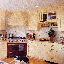

In [15]:
#check to make sure the labels correspond to the correct images
array_to_img(train_images[1412])


In [16]:
train_y[1412]

array([1.], dtype=float32)

__Reshape Image Arrays for CNN Use__

In [19]:
# Explore your datasets again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 1679
Number of testing samples: 390
Number of validation samples: 363
train_images shape: (1679, 64, 64, 3)
train_labels shape: (1679, 2)
test_images shape: (390, 64, 64, 3)
test_labels shape: (390, 2)
val_images shape: (363, 64, 64, 3)
val_labels shape: (363, 2)


In [125]:
#reshape our train,test,val image datasets 
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape, '= train size')
print(test_img.shape, '= test size')  
print(val_img.shape, '= val size')

(1672, 12288) = train size
(390, 12288) = test size
(363, 12288) = val size


# CNN Models

In [126]:
#import necessary libraries
from keras import models
from keras import layers

__Densely Connected Network: Baseline Model__

In [127]:
#instantiate our model and add our hidden layers
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(15, activation='relu', input_shape=(12288,)))#3 hidden layers
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [128]:
#compile our model and fit it to our training data
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history1 = model.fit(train_img,
                    train_y,
                    epochs=100,
                    batch_size=1672,
                    validation_data=(val_img, val_y))

ValueError: Input arrays should have the same number of samples as target arrays. Found 1672 input samples and 1679 target samples.

In [25]:
#examine our evaluation metrics for how our model on the training set
results_train = model.evaluate(train_img, train_y)

1679/1679 [==============================] - 0s 97us/step


In [26]:
#examine our evaluation metrics for how our model performed on the test set 
results_test = model.evaluate(test_img, test_y)

390/390 [==============================] - 0s 235us/step


In [27]:
# print the [loss, and accuracy] of our training data
results_train

[0.6241408023825709, 0.634306134657181]

In [28]:
#print the [loss and accuracy] of our test data
results_test

[0.5538608187284225, 0.7512820509763865]

__ConvNet: Initial Model__

In [58]:
#import earlystopping from keras and set a variable called earlystopping that ends our run model if our validation loss doesnt increase by a certain amount
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 7) 

In [59]:
# get all the data in the directory split/test (271 images), and reshape them
# get all the data in the directory split/train (2477 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(64, 64), batch_size= batch_size_train)


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(64, 64), batch_size = batch_size_test)   

# get all the data in the directory split/validation (257 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(64, 64), batch_size = batch_size_val) 

Found 1680 images belonging to 2 classes.
Found 390 images belonging to 2 classes.
Found 363 images belonging to 2 classes.


In [60]:
#instantiate our cnn_model with conv layers and maxpooling and a flatten layer as our last hidden layer 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape = (64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [123]:
#fit our cnn to the training set 
history = model.fit(train_images,
                    train_y,
                    epochs=75,
                    batch_size=32,
                    validation_data=(val_images, val_y), callbacks = [early_stopping]) 

ValueError: Input arrays should have the same number of samples as target arrays. Found 1672 input samples and 1679 target samples.

In [34]:
#save my model to drive only need to do this once
model_json = model.to_json()
with open("model_cnn_one.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_one.h5")
print("Saved model to drive")

Saved model to drive


__Evaluating Initial CNN Model__


Not sure if our model is actually able to determine clean or dirty rooms or if there is just a common feature or patern outside of the desired image content for our training set data that results in our model overfitting. So want to check how it is performing on each one of our datasets where our test and validation datasets have been vetted, filtered and entirely cleaned. 

In [ ]:
#examine our evaluation metrics for how our model performed on the test set 
results_one_test = model.evaluate(test_images, test_y)

#and our training data
results_one_train = model.evaluate(train_images, train_y)

#do the same for our validation images and targets
results_one_validate = model.evaluate(val_images, val_y)

In [155]:
# print the [loss, and accuracy] of our training data
model_one_acc_train = results_train

[0.10548747599373409, 0.9785586658725431]

In [160]:
# check the results for our validation set 
model_one_acc_val = results_validate

[0.5012925851866196, 0.7923497271016647]

In [156]:
#print the [loss and accuracy] of our test data
model_one_acc_test = results_test

[0.42742275641514704, 0.8384615381558737]

__Save our Model Weights and Probabilities__

In [195]:
#going to try and use this model to output a predictive value 
model_proba_train = model.predict_proba(train_images)

#examining the probability as a metric for how dirty or clean a room will be 
model_proba_test = model.predict_proba(test_images)

In [199]:
#examine our probabilities that are being fed into the output layer and then converted to a 0 or 1 using the sigmoid function
probabilities_train[10:20]

array([[0.5098092 ],
       [0.51501226],
       [0.5183643 ],
       [0.52975327],
       [0.51047295],
       [0.5255894 ],
       [0.51938426],
       [0.5157531 ],
       [0.52049375],
       [0.51514107]], dtype=float32)

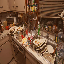

In [189]:
array_to_img(test_images[10:20])

__VGG Model__

In [41]:
#import necessary model for transfer learning
from keras.applications import VGG16
from keras.layers import Dense, Dropout
#instantiate our base_model with VGG16 after removing an output layer and altering the input shape
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (64,64,3))

In [42]:
# instantiate our new model and add a layer to the pretrained base_model
model = models.Sequential()

model.add(base_model) 

model.add(Dense(512, activation ='relu')) #, data_format = 'channels_last')

model.add(Dropout(0.4)) 

model.add(Dense(64, activation ='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64))


model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [43]:
#compile our model using binary_crossentropy as the loss parameter
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [44]:
#make sure that we do not retrain the first 16 pretrained layers of our model
for layer in model.layers[:16]:
    layer.trainable = False
for layer in model.layers[16:]:
    layer.trainable = True

In [ ]:
#fit our train images and train labels to our ResNet transfer learning model
history_2 = model.fit(train_images,
                    train_y,
                    epochs=75,
                    batch_size=32,
                    validation_data=(val_images, val_y), callbacks = [early_stopping]) 

/Users/AlexGaujean/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 1679 samples, validate on 366 samples
Epoch 1/75
 320/1679 [====>.........................] - ETA: 3:07 - loss: 0.6858 - acc: 0.6031

In [ ]:
#save our weights and model to our folder
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights_vgg.h5")
print("Saved model to drive")

In [ ]:
model.summary()

__Resnet Model__

In [49]:
#import necessary libraries for ResNet
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import 

In [47]:
#instantiate a base_model with our ResNet layer
base_model = ResNet50(weights='imagenet', include_top = False)

/Users/AlexGaujean/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 11s 0us/step


In [55]:
#setup our model with the ResNet as the base and add a few more hidden layers
model = models.Sequential()

model.add(base_model) 

model.add(GlobalAveragePooling2D())

model.add(Dense(1024,  activation='relu')) 
model.add(Dropout(0.4)) 

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))


model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
#compile our model using binary_crossentropy as the loss parameter
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [ ]:
#make sure that we do not retrain the first 16 pretrained layers of our model
for layer in model.layers[:50]:
    layer.trainable = False
for layer in model.layers[50:]:
    layer.trainable = True

In [ ]:
#fit our training images and training labels to our model
history_3 = model.fit(train_images,
                    train_y,
                    epochs=75,
                    batch_size=32,
                    validation_data=(val_images, val_y), callbacks = [early_stopping])

# Visualizing our Layers

In [87]:
from keras import models
from keras.layers import Dense, Dropout

In [117]:
!pwd

/Users/AlexGaujean/Downloads/data


In [ ]:
#use our locally saved variable of our model outputs [list of tensors] to select an image tensor
img_tensor = model_res_outputs[150]
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

In [122]:
#use our locally saved variable of our model outputs [list of tensors] to select an image tensor
img_tensor = model_vgg_outputs[150]
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

NameError: name 'model_vgg_outputs' is not defined

In [132]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:10]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

NameError: name 'img_tensor' is not defined

NameError: name 'activations' is not defined

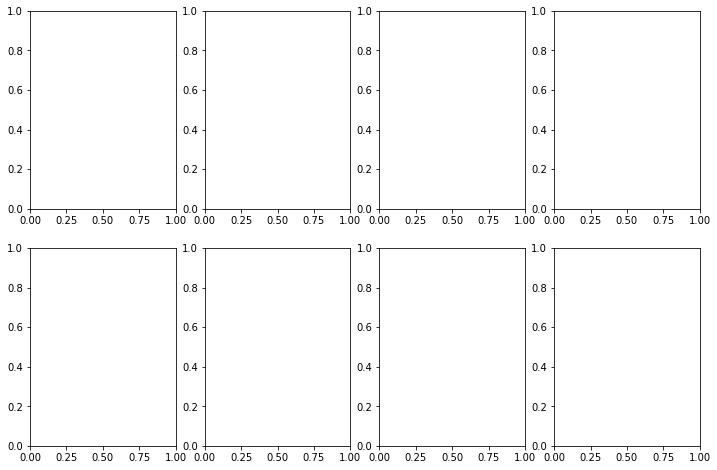

In [121]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

In [147]:
auc_dict = {'Model': ['Baseline','Baseline', 'Simple_ConvNet', 'Simple_ConvNet', 'VGG16', 'VGG16','ResNet', 'ResNet'], 
            'Accuracy': [.6337, .7513, .7784, .7795, .9988, .9051, .5455, .6948], 
            'type':['Train','Test','Train','Test','Train','Test','Train','Test']}

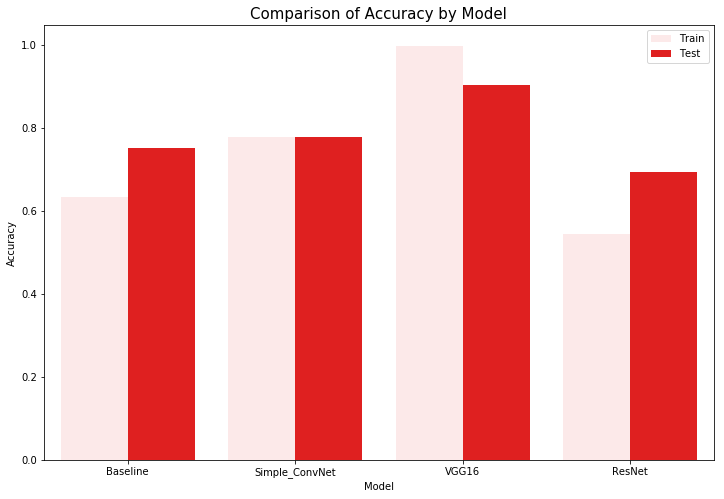

In [148]:
# Bar plot
plt.figure(figsize=(12,8))
accuracy = pd.DataFrame(auc_dict, columns = auc_dict.keys())
ax = sns.barplot(x="Model", y="Accuracy", hue="type", data=accuracy, color='red')
plt.title('Comparison of Accuracy by Model',fontsize = 15)
plt.legend(loc="upper right")

In [146]:
!pwd

/Users/AlexGaujean/Downloads/data
